##### **NLP - HW2 - Part1**
##### Student name: **Majid Adibian**
##### Student number: **400131078**

##### install packages

In [ ]:
!pip install --upgrade gensim
!pip install arabic-reshaper
!pip install python-bidi

You should consider upgrading via the 'c:\users\majid\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


##### download data

In [ ]:
!gdown --id 1-86CqCHek-U1iH5nW30RfnFU0PYmdhKB 
!gdown --id 1YzRlYyye_KoEw7_q9NARiCwl3Cn-EH3J 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-86CqCHek-U1iH5nW30RfnFU0PYmdhKB
To: /content/train.csv
100% 20.1M/20.1M [00:00<00:00, 68.3MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1YzRlYyye_KoEw7_q9NARiCwl3Cn-EH3J
To: /content/test.csv
100% 2.03M/2.03M [00:00<00:00, 190MB/s]


##### import liberaries

In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from bidi.algorithm import get_display
import arabic_reshaper

mian_path = ''

### step 1

##### read data

In [ ]:
train_data = pd.read_csv(mian_path + 'train.csv')
train_data.head()

,id,article
0,Doc26,# آيا مشكل اصلي سينماي ايران فيلمنامه است ؟ # ...
1,Doc591,ضمن تؤمين معاش مردم و فراهم كردن زمينه هاي زند...
2,Doc810,كارشناسان مي گويند با روند وضع موجود، ترافيك ت...
3,Doc514,سرپرست تيم فوتبال پيروزي گفت : موضوع استخدام ا...
4,Doc469,# سخنان رهبر انقلاب # روزنامه رسالت در سرمقال...


##### convert docs to list of tokens

In [ ]:
def preplocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    return text.split()

def tokenize_data(data):
    tokenized_data = {}
    for index, row in data.iterrows():
        tokens = preplocess_text(row['article'])
        tokenized_data[row['id']] = tokens
    return tokenized_data

docs_tokenized = tokenize_data(train_data)

##### train word2vec

In [ ]:
docs_tokens = docs_tokenized.values()
word2vec_model = gensim.models.Word2Vec(sentences=docs_tokens, vector_size=300, window=5, sg=1, min_count=1, workers=4)

### step 2

#### step 2.1: calculate doc vector using word2vec and tfidf

##### calculate tfidf 

In [ ]:
def get_tfidf(docs_tokenized):
    docs_ids = []
    docs_tokens = []
    for doc_id, tokens in docs_tokenized.items():
        docs_tokens.append(tokens)
        docs_ids.append(doc_id)
    dictionary = Dictionary()
    BoW_corpus = [dictionary.doc2bow(tokens, allow_update=True) for tokens in docs_tokens]
    tfidf = TfidfModel(BoW_corpus, smartirs='ntc')
    docs_terms_tfidf = {}
    for i, doc in enumerate(tfidf[BoW_corpus]):
        docs_terms_tfidf[docs_ids[i]] = {dictionary[id]: freq for id, freq in doc}
    return docs_terms_tfidf

docs_terms_tfidf = get_tfidf(docs_tokenized)

##### calculate doc vector using word2vec and tfidf

In [ ]:
def get_doc_vec1(doc_terms_tfidf, word2vec):
    vec = np.zeros(word2vec.wv.get_vector(next(iter(doc_terms_tfidf))).shape)
    for word, freq in doc_terms_tfidf.items():
        try:
            vec += (word2vec.wv.get_vector(word) * freq)
        except:
            pass
    return vec

def get_docs_vec1(docs_terms_tfidf, word2vec):
    docs_vec = {}
    l = 0
    for doc_id, doc_terms_tfidf in docs_terms_tfidf.items():
        vec = get_doc_vec1(doc_terms_tfidf, word2vec)
        docs_vec[doc_id] = vec
    return docs_vec

docs_vec1 = get_docs_vec1(docs_terms_tfidf, word2vec_model)

#### step 2.2: calculate doc vector using doc2vec

##### train doc2vec model

In [ ]:
taged_docs = [TaggedDocument(tokens, [doc_id]) for doc_id, tokens in docs_tokenized.items()]
doc2vec_model = Doc2Vec(taged_docs, vector_size=300, window=5, min_count=1, workers=4)

##### calculate doc vector using doc2vec

In [ ]:
def get_docs_vec2(doc2vec_model, docs_tokenized):
    docs_vec = {}
    for doc_id, tokens in docs_tokenized.items():
        docs_vec[doc_id] = doc2vec_model.infer_vector(tokens)
    return docs_vec

docs_vec2 = get_docs_vec2(doc2vec_model, docs_tokenized)

### step 3

##### read test data and create doc vectors using above functions

In [ ]:
test_data = pd.read_csv(mian_path + 'test.csv')
test_docs_tokenized = tokenize_data(test_data)
test_docs_terms_tfidf = get_tfidf(test_docs_tokenized)
test_docs_vec1 = get_docs_vec1(test_docs_terms_tfidf, word2vec_model)
test_docs_vec2 = get_docs_vec2(doc2vec_model, test_docs_tokenized)

##### find most similar doc to the input doc

In [ ]:
def find_most_similar_doc(train_docs_vec, test_docs_vec, input_doc_id):
    input_doc_vec = test_docs_vec[input_doc_id]
    similar_doc = max(train_docs_vec.keys(), key=lambda x: cosine_similarity([train_docs_vec[x]], [input_doc_vec])[0][0])
    similarity = cosine_similarity([train_docs_vec[similar_doc]], [input_doc_vec])[0][0]
    return similar_doc, similarity

In [ ]:
test_docs_id = ['Doc1', 'Doc3', 'Doc5', 'Doc25', 'Doc36']
print('Doc vector using tfidf:')
for input_doc_id in test_docs_id:
    similar_doc, similarity = find_most_similar_doc(docs_vec1, test_docs_vec1, input_doc_id)
    print('\tMost similar doc to {0} is {1}: cosin similarity = {2:.4f}'.format(input_doc_id, similar_doc, similarity))
    
print('Doc vector using Doc2vec:')
for input_doc_id in test_docs_id:
    similar_doc, similarity = find_most_similar_doc(docs_vec2, test_docs_vec2, input_doc_id)
    print('\tMost similar doc to {0} is {1}: cosin similarity = {2:.4f}'.format(input_doc_id, similar_doc, similarity))

Doc vector using tfidf:
	Most similar doc to Doc1 is Doc165: cosin similarity = 0.9885
	Most similar doc to Doc3 is Doc19: cosin similarity = 0.9950
	Most similar doc to Doc5 is Doc26: cosin similarity = 0.9884
	Most similar doc to Doc25 is Doc679: cosin similarity = 0.9998
	Most similar doc to Doc36 is Doc667: cosin similarity = 0.9837
Doc vector using Doc2vec:
	Most similar doc to Doc1 is Doc33: cosin similarity = 0.6962
	Most similar doc to Doc3 is Doc19: cosin similarity = 0.8798
	Most similar doc to Doc5 is Doc7: cosin similarity = 0.7016
	Most similar doc to Doc25 is Doc679: cosin similarity = 0.9912
	Most similar doc to Doc36 is Doc550: cosin similarity = 0.7047


### step 4

##### find the most similar words to the inputs word

In [ ]:
def get_most_similar_words(input_word, word2vec_model):
    similar_words = word2vec_model.wv.most_similar(positive=input_word, topn=3)
    similar_words = {w[0]: round(w[1], 3) for w in similar_words}
    return similar_words

In [ ]:
similar_words = {}
for word in ['تهران', 'بهداشت', 'دفاع', 'رودخانه', 'سرد', 'فرهنگ', 'استقلال']:
    print('3 most similar words for {}:'.format(word))
    similar_words[word] = get_most_similar_words(word, word2vec_model)
    print('\t' + str(similar_words[word]))

3 most similar words for تهران:
	{'اصفهان': 0.615, 'تبريز': 0.585, 'پاريس': 0.58}
3 most similar words for بهداشت:
	{'باروري': 0.778, 'بهداشتي': 0.738, 'مراقبتهاي': 0.726}
3 most similar words for دفاع:
	{'مقدس': 0.683, 'ضدموشكي': 0.655, 'پشتيباني': 0.651}
3 most similar words for رودخانه:
	{'درياچه': 0.839, 'كارون': 0.811, 'ارتفاعات': 0.804}
3 most similar words for سرد:
	{'زمستان': 0.793, 'مرطوب': 0.778, 'بادهاي': 0.775}
3 most similar words for فرهنگ:
	{'ارشاد': 0.767, 'سمعي': 0.701, 'تمدن': 0.692}
3 most similar words for استقلال:
	{'تماميت': 0.68, 'پاس': 0.671, 'ارضي': 0.66}


##### use PCA to plot similar words

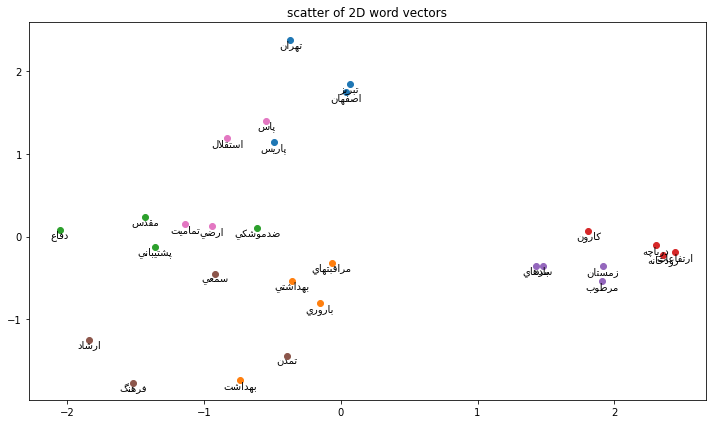

In [ ]:
def get_PCA(words_similarity, word2vec_model,  dim):
    vecs = []
    for word, sim_words in words_similarity.items():
        vecs.append(word2vec_model.wv[word])
        for w in sim_words:
            vecs.append(word2vec_model.wv[w])
    vecs = np.array(vecs)
    pca = PCA(n_components=dim)
    pca.fit(vecs)
    return pca

def plot_points(all_vecs, all_words, dim):
    if dim == 2:
        plt.rcParams["figure.figsize"] = (10,6)
        for i, vecs in enumerate(all_vecs):
            words = all_words[i]
            plt.scatter(x=[v[0] for v in vecs], y=[v[1] for v in vecs])
            for j, vec in enumerate(vecs):
                word = words[j]
                word = arabic_reshaper.reshape(word)
                word = get_display(word) 
                plt.text(vec[0], vec[1], word, horizontalalignment='center',verticalalignment='top')
        plt.title('scatter of 2D word vectors')
    else:
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        for i, vecs in enumerate(all_vecs):
            words = all_words[i]
            ax.scatter3D([v[0] for v in vecs], [v[1] for v in vecs], [v[2] for v in vecs])
            for j, vec in enumerate(vecs):
                word = words[j]
                word = arabic_reshaper.reshape(word) 
                word = get_display(word) 
                ax.text(vec[0], vec[1], vec[2], word, horizontalalignment='center',verticalalignment='top')
        plt.title('scatter of 3D word vectors')
    plt.tight_layout()
    plt.show()

def word_vec_represent(words_similarity, word2vec_model, dim):
    pca = get_PCA(words_similarity, word2vec_model, dim)
    all_vecs = []
    all_words = []
    for word, sim_words in words_similarity.items():
        vecs = []
        words = [word]
        vec = word2vec_model.wv.get_vector(word)
        vecs.append(pca.transform([vec])[0])
        for w in sim_words:
            vec = word2vec_model.wv.get_vector(w)
            vecs.append(pca.transform([vec])[0])
            words.append(w)
        all_vecs.append(vecs)
        all_words.append(words)
    plot_points(all_vecs, all_words, dim)
    
word_vec_represent(similar_words, word2vec_model, 2)

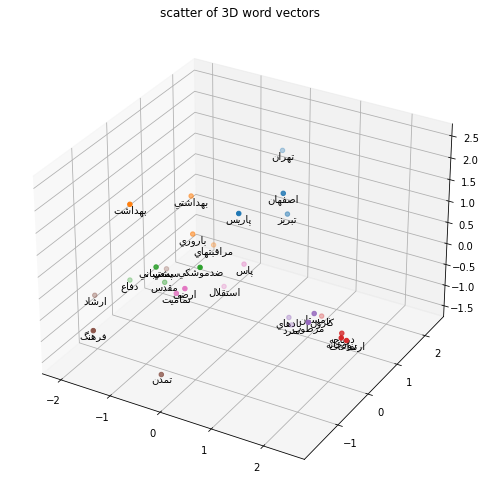

In [ ]:
word_vec_represent(similar_words, word2vec_model, 3)